In [1]:
import matplotlib.pyplot as plt
import numpy as np

from pathlib import Path

from astropy.nddata import CCDData
from astropy.stats import mad_std
from astropy.visualization import simple_norm
import ccdproc as ccdp

In [2]:
DEBUG = False

if not DEBUG:
    import warnings
    import logging
    from astropy.wcs import FITSFixedWarning
    from astropy.io.fits.verify import VerifyWarning
    from astropy import logger

    warnings.simplefilter('ignore', FITSFixedWarning)
    warnings.simplefilter('ignore', VerifyWarning)
    logging.getLogger('astropy').setLevel(logging.ERROR)
else:
    import warnings
    import logging
    from astropy.wcs import FITSFixedWarning
    from astropy.io.fits.verify import VerifyWarning
    from astropy import logger
    
    warnings.simplefilter('default', FITSFixedWarning)
    warnings.simplefilter('default', VerifyWarning)
    logging.getLogger('astropy').setLevel(logging.INFO)

In [3]:
files = ccdp.ImageFileCollection('../data/bias')
files.summary['file', 'imagetyp', 'exptime', 'naxis1', 'naxis2', 'gain', 'egain']

file,imagetyp,exptime,naxis1,naxis2,gain,egain
str35,str10,float64,int64,int64,int64,float64
B_M82_1093_Bin1x1_0.000032s_16C.fit,Bias Frame,3.2e-05,3840,2160,252,0.620981216430664
B_M82_1094_Bin1x1_0.000032s_16C.fit,Bias Frame,3.2e-05,3840,2160,252,0.620981216430664
B_M82_1095_Bin1x1_0.000032s_16C.fit,Bias Frame,3.2e-05,3840,2160,252,0.620981216430664
B_M82_1096_Bin1x1_0.000032s_15C.fit,Bias Frame,3.2e-05,3840,2160,252,0.620981216430664
B_M82_1097_Bin1x1_0.000032s_15C.fit,Bias Frame,3.2e-05,3840,2160,252,0.620981216430664
B_M82_1098_Bin1x1_0.000032s_15C.fit,Bias Frame,3.2e-05,3840,2160,252,0.620981216430664
B_M82_1099_Bin1x1_0.000032s_15C.fit,Bias Frame,3.2e-05,3840,2160,252,0.620981216430664
B_M82_1100_Bin1x1_0.000032s_15C.fit,Bias Frame,3.2e-05,3840,2160,252,0.620981216430664
B_M82_1101_Bin1x1_0.000032s_15C.fit,Bias Frame,3.2e-05,3840,2160,252,0.620981216430664


In [4]:
#копируем файлы из папки data в папку reduced
calibrated_data = Path('../reduced')
calibrated_data.mkdir(exist_ok=True)

biases = files.files_filtered(imagetyp='Bias Frame', include_path=True)

import shutil

for bias in biases:
    shutil.copy(bias, calibrated_data)

In [5]:
calibrated_path = Path('../reduced')
reduced_images = ccdp.ImageFileCollection(calibrated_path)

calibrated_biases = reduced_images.files_filtered(imagetyp='Bias Frame', include_path=True)

#возьмем 1 кадр для тестов
bias_file = calibrated_biases[0] 
bias_ccd = CCDData.read(bias_file, unit='adu') 

bias_data = bias_ccd.data

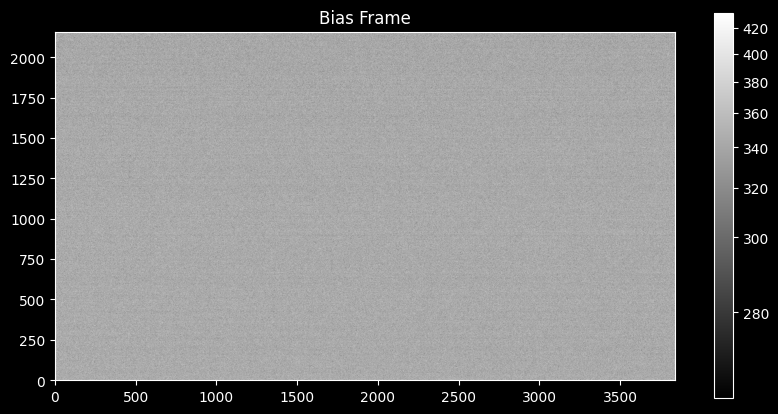

In [6]:
norm = simple_norm(bias_data, stretch='sqrt', percent=99)
plt.style.use("dark_background")
plt.figure(figsize=(10, 5))
plt.imshow(bias_data, cmap='gray', norm=norm, origin='lower')
plt.colorbar()
plt.title('Bias Frame')
plt.show()

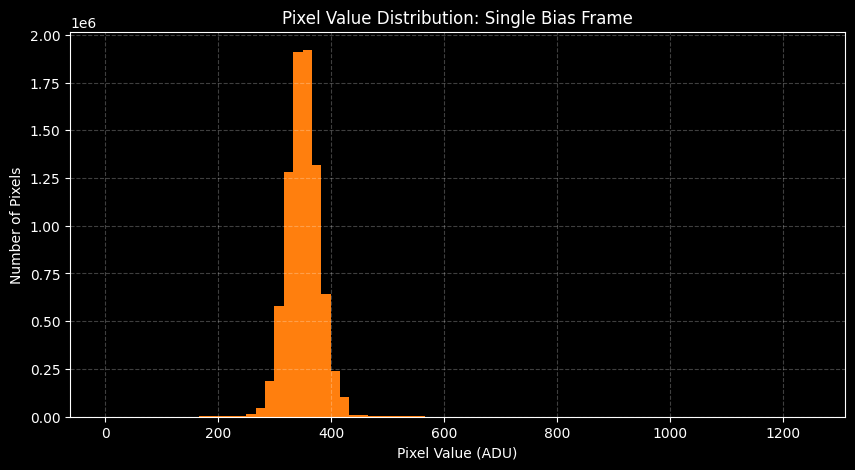

In [7]:
bias_hist = bias_data.flatten()

plt.figure(figsize=(10, 5))
plt.hist(bias_hist, bins=75, color='tab:orange')
plt.title('Pixel Value Distribution: Single Bias Frame')
plt.xlabel('Pixel Value (ADU)')
plt.ylabel('Number of Pixels')
plt.grid(linestyle='dashed', alpha=0.25)
plt.show()

In [8]:
combined_bias_avg = ccdp.combine(calibrated_biases,
                             method='average',
                             sigma_clip=True, sigma_clip_low_thresh=5, sigma_clip_high_thresh=5,
                             sigma_clip_func=np.ma.median, sigma_clip_dev_func=mad_std,
                             mem_limit=360e6,
                             unit='adu')

combined_bias_avg.meta['combined'] = True

combined_bias_avg.write(calibrated_path / 'combined_bias_avg.fit', overwrite=True)

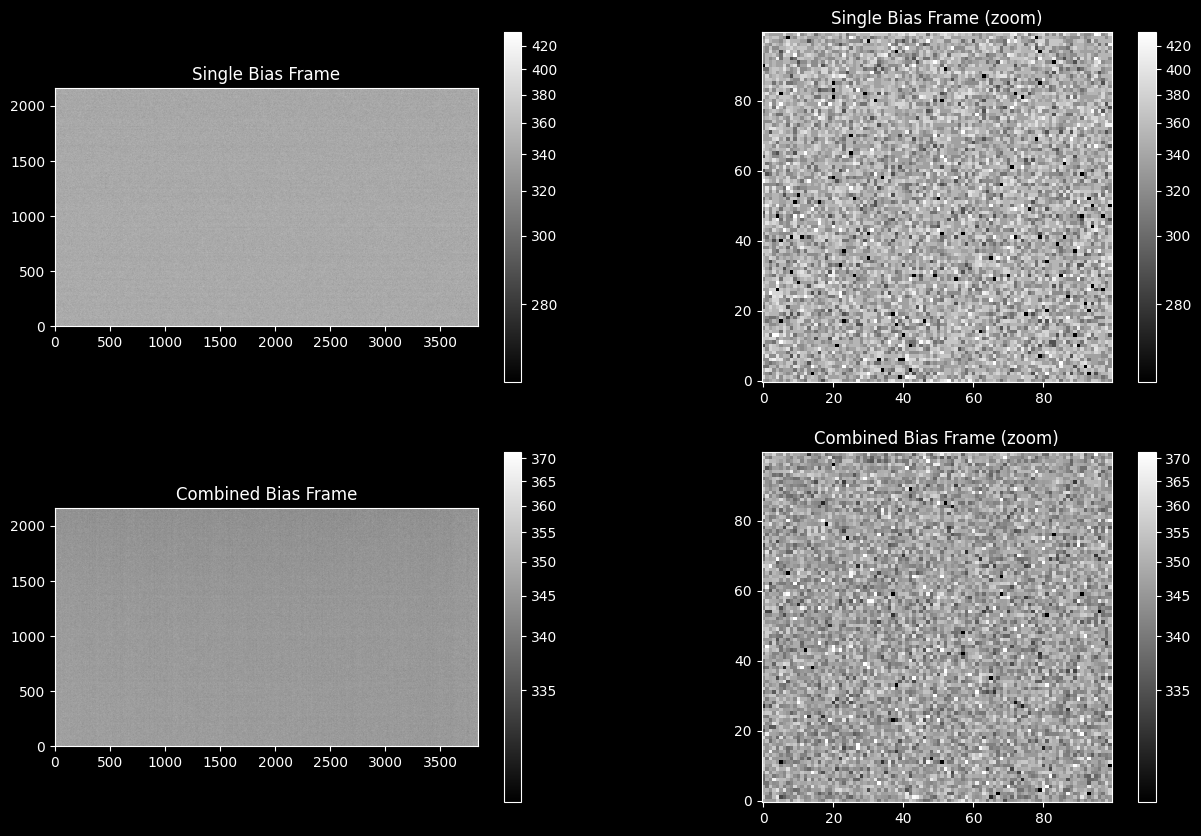

In [9]:
fig, axes = plt.subplots(2, 2, figsize=(15,10))
ax1, ax2, ax3, ax4 = axes.flatten()

norm = simple_norm(bias_data, stretch='sqrt', percent=99)
im1 = ax1.imshow(bias_data, cmap='gray', norm=norm, origin='lower')
ax1.set_title('Single Bias Frame')
fig.colorbar(im1, ax=ax1)

norm = simple_norm(bias_data, stretch='sqrt', percent=99)
im2 = ax2.imshow(bias_data[0:100, 0:100], cmap='gray', norm=norm, origin='lower')
ax2.set_title('Single Bias Frame (zoom)')
fig.colorbar(im2, ax=ax2)

norm = simple_norm(combined_bias_avg.data, stretch='sqrt', percent=99)
im3 = ax3.imshow(combined_bias_avg.data, cmap='gray', norm=norm, origin='lower')
ax3.set_title('Combined Bias Frame')
fig.colorbar(im3, ax=ax3)

norm = simple_norm(combined_bias_avg.data, stretch='sqrt', percent=99)
im4 = ax4.imshow(combined_bias_avg.data[0:100, 0:100], cmap='gray', norm=norm, origin='lower')
ax4.set_title('Combined Bias Frame (zoom)')
fig.colorbar(im4, ax=ax4)

plt.show()


          |  Single Bias Frame  |  Combined Bias Frame  
--------------------------------------------------------
Mean      |        345.55       |         346.04        
STD       |        30.06        |          6.69         
MAD STD   |        23.72        |          5.80         


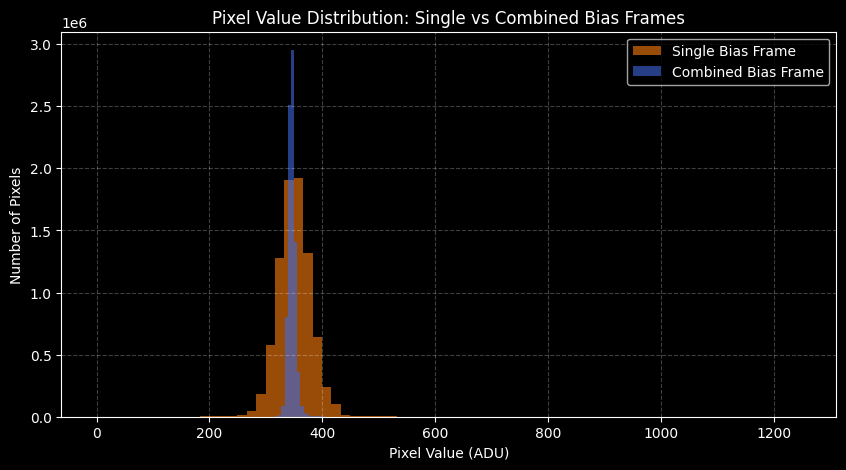

In [10]:
combined_bias_avg_hist = combined_bias_avg.data.flatten()

print(f'{"":<10}| {"Single Bias Frame":^20}| {"Combined Bias Frame":^22}')
print('-' * 56)
print(f'{"Mean":<10}| {np.mean(bias_data):^20.2f}| {np.mean(combined_bias_avg.data):^22.2f}')
print(f'{"STD":<10}| {np.std(bias_data):^20.2f}| {np.std(combined_bias_avg.data):^22.2f}')
print(f'{"MAD STD":<10}| {mad_std(bias_data):^20.2f}| {mad_std(combined_bias_avg.data):^22.2f}')


plt.style.use("dark_background")
plt.figure(figsize=(10, 5))
plt.hist(bias_hist, bins=75, color='tab:orange', alpha=0.6, label='Single Bias Frame')
plt.hist(combined_bias_avg_hist, bins=75, color='royalblue', alpha=0.6, label='Combined Bias Frame')
plt.title('Pixel Value Distribution: Single vs Combined Bias Frames')
plt.xlabel('Pixel Value (ADU)')
plt.ylabel('Number of Pixels')
plt.grid(linestyle='dashed', alpha=0.25)
plt.legend()
plt.show()

In [11]:
combined_bias_median = ccdp.combine(calibrated_biases,
                             method='median',
                             sigma_clip=True, sigma_clip_low_thresh=5, sigma_clip_high_thresh=5,
                             sigma_clip_func=np.ma.median, sigma_clip_dev_func=mad_std,
                             mem_limit=360e6,
                             unit='adu')

combined_bias_median.meta['combined'] = True

combined_bias_median.write(calibrated_path / 'combined_bias_median.fit', overwrite=True)

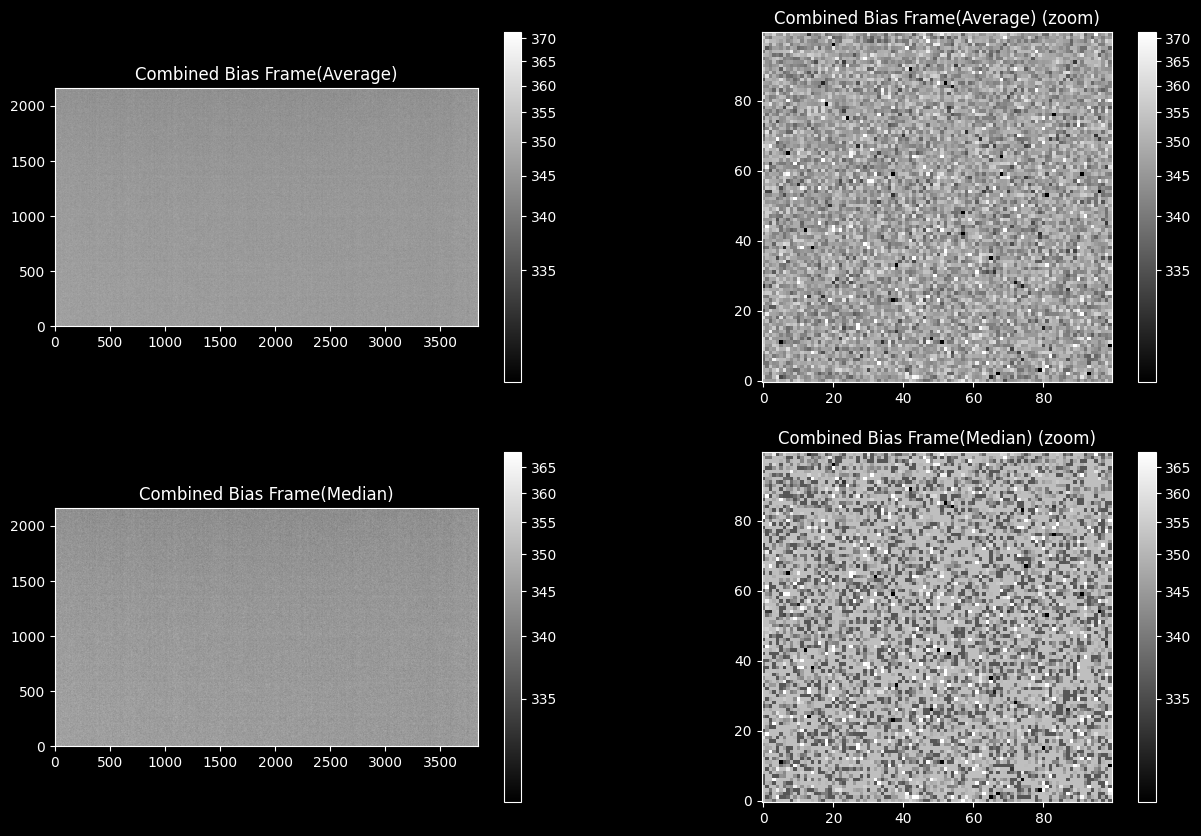

In [12]:
fig, axes = plt.subplots(2, 2, figsize=(15,10))
ax1, ax2, ax3, ax4 = axes.flatten()

norm = simple_norm(combined_bias_avg.data, stretch='sqrt', percent=99)
im1 = ax1.imshow(combined_bias_avg.data, cmap='gray', norm=norm, origin='lower')
ax1.set_title('Combined Bias Frame(Average)')
fig.colorbar(im1, ax=ax1)

norm = simple_norm(combined_bias_avg.data, stretch='sqrt', percent=99)
im2 = ax2.imshow(combined_bias_avg.data[0:100, 0:100], cmap='gray', norm=norm, origin='lower')
ax2.set_title('Combined Bias Frame(Average) (zoom)')
fig.colorbar(im2, ax=ax2)

norm = simple_norm(combined_bias_median.data, stretch='sqrt', percent=99)
im3 = ax3.imshow(combined_bias_median.data, cmap='gray', norm=norm, origin='lower')
ax3.set_title('Combined Bias Frame(Median)')
fig.colorbar(im3, ax=ax3)

norm = simple_norm(combined_bias_median.data, stretch='sqrt', percent=99)
im4 = ax4.imshow(combined_bias_median.data[0:100, 0:100], cmap='gray', norm=norm, origin='lower')
ax4.set_title('Combined Bias Frame(Median) (zoom)')
fig.colorbar(im4, ax=ax4)

plt.show()

            | Combined Bias Frame (Average) |  Combined Bias Frame (Median) 
---------------------------------------------------------------------------
Mean        |             346.04            |             345.86            
STD         |              6.69             |              7.84             
MAD STD     |              5.80             |              6.47             


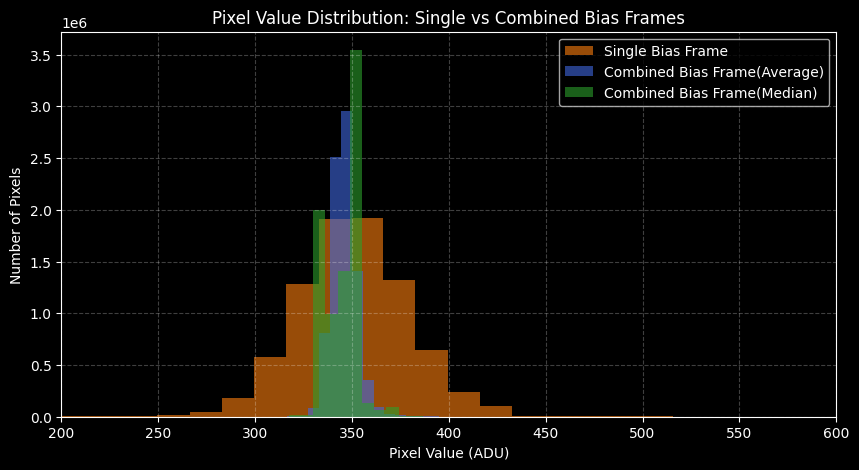

In [13]:
combined_bias_median_hist = combined_bias_median.data.flatten()

print(f'{"":<12}| {"Combined Bias Frame (Average)":^30}| {"Combined Bias Frame (Median)":^30}')
print('-' * 75)
print(f'{"Mean":<12}| {np.mean(combined_bias_avg.data):^30.2f}| {np.mean(combined_bias_median.data):^30.2f}')
print(f'{"STD":<12}| {np.std(combined_bias_avg.data):^30.2f}| {np.std(combined_bias_median.data):^30.2f}')
print(f'{"MAD STD":<12}| {mad_std(combined_bias_avg.data):^30.2f}| {mad_std(combined_bias_median.data):^30.2f}')

plt.style.use("dark_background")
plt.figure(figsize=(10, 5))
plt.hist(bias_hist, bins=75, color='tab:orange', alpha=0.6, label='Single Bias Frame')
plt.hist(combined_bias_avg_hist, bins=75, color='royalblue', alpha=0.6, label='Combined Bias Frame(Average)')
plt.hist(combined_bias_median_hist, bins=75, color='tab:green', alpha=0.6, label='Combined Bias Frame(Median)')
plt.title('Pixel Value Distribution: Single vs Combined Bias Frames')
plt.xlabel('Pixel Value (ADU)')
plt.ylabel('Number of Pixels')
plt.xlim(200, 600)
plt.grid(linestyle='dashed', alpha=0.25)
plt.legend()
plt.show()

In [14]:
combined_bias_avg_sc2 = ccdp.combine(calibrated_biases,
                             method='average',
                             sigma_clip=True, sigma_clip_low_thresh=2, sigma_clip_high_thresh=2,
                             sigma_clip_func=np.ma.median, sigma_clip_dev_func=mad_std,
                             mem_limit=360e6,
                             unit='adu')

combined_bias_avg_sc2.meta['combined'] = True

combined_bias_avg_sc2.write(calibrated_path / 'combined_bias_avg_sc2.fit', overwrite=True)

In [15]:
combined_bias_avg_sc3 = ccdp.combine(calibrated_biases,
                             method='average',
                             sigma_clip=True, sigma_clip_low_thresh=3, sigma_clip_high_thresh=3,
                             sigma_clip_func=np.ma.median, sigma_clip_dev_func=mad_std,
                             mem_limit=360e6,
                             unit='adu')

combined_bias_avg_sc3.meta['combined'] = True

combined_bias_avg_sc3.write(calibrated_path / 'combined_bias_avg_sc3.fit', overwrite=True)

In [16]:
combined_bias_avg_sc4 = ccdp.combine(calibrated_biases,
                             method='average',
                             sigma_clip=True, sigma_clip_low_thresh=4, sigma_clip_high_thresh=4,
                             sigma_clip_func=np.ma.median, sigma_clip_dev_func=mad_std,
                             mem_limit=360e6,
                             unit='adu')

combined_bias_avg_sc4.meta['combined'] = True

combined_bias_avg_sc4.write(calibrated_path / 'combined_bias_avg_sc4.fit', overwrite=True)

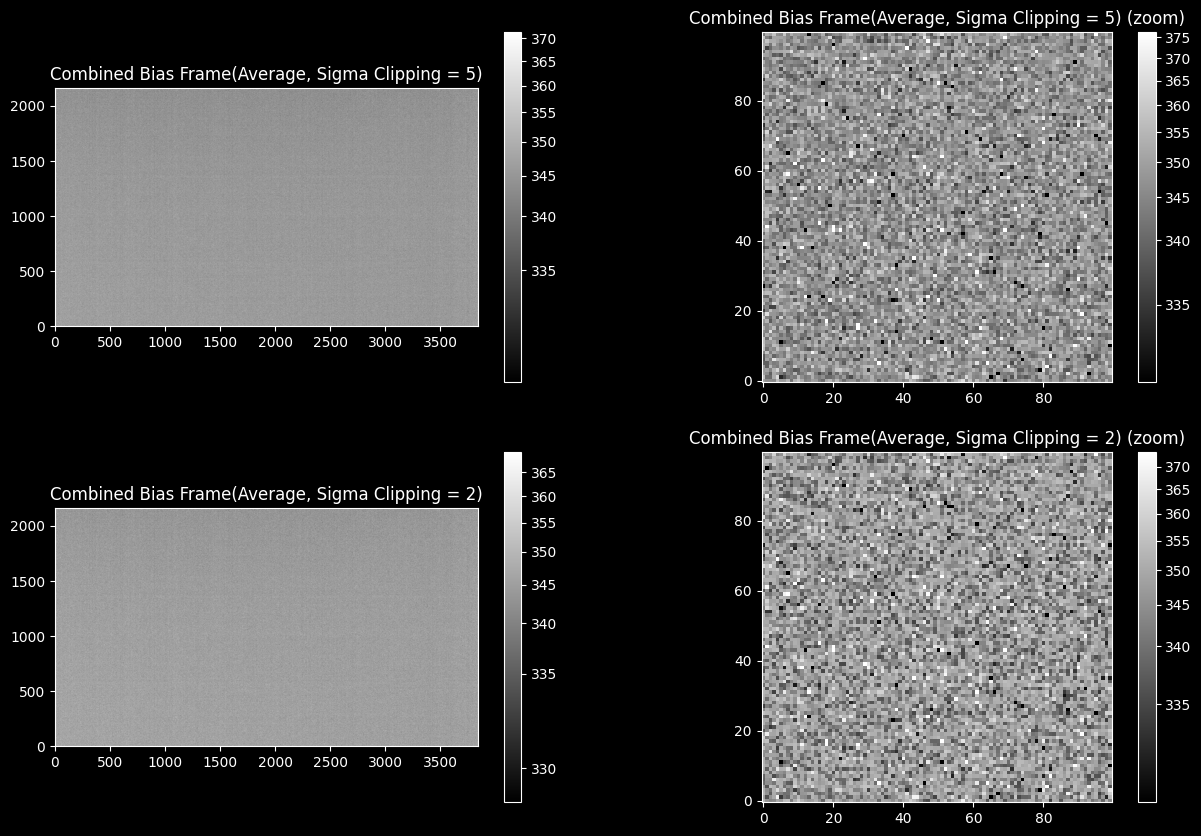

In [17]:
fig, axes = plt.subplots(2, 2, figsize=(15,10))
ax1, ax2, ax3, ax4 = axes.flatten()

norm = simple_norm(combined_bias_avg.data, stretch='sqrt', percent=99)
im1 = ax1.imshow(combined_bias_avg.data, cmap='gray', norm=norm, origin='lower')
ax1.set_title('Combined Bias Frame(Average, Sigma Clipping = 5)')
fig.colorbar(im1, ax=ax1)

norm = simple_norm(combined_bias_avg.data[0:100, 0:100], stretch='sqrt', percent=99)
im2 = ax2.imshow(combined_bias_avg.data[0:100, 0:100], cmap='gray', norm=norm, origin='lower')
ax2.set_title('Combined Bias Frame(Average, Sigma Clipping = 5) (zoom)')
fig.colorbar(im2, ax=ax2)

norm = simple_norm(combined_bias_avg_sc2.data, stretch='sqrt', percent=99)
im3 = ax3.imshow(combined_bias_avg_sc2.data, cmap='gray', norm=norm, origin='lower')
ax3.set_title('Combined Bias Frame(Average, Sigma Clipping = 2)')
fig.colorbar(im3, ax=ax3)

norm = simple_norm(combined_bias_avg_sc2.data[0:100, 0:100], stretch='sqrt', percent=99)
im4 = ax4.imshow(combined_bias_avg_sc2.data[0:100, 0:100], cmap='gray', norm=norm, origin='lower')
ax4.set_title('Combined Bias Frame(Average, Sigma Clipping = 2) (zoom)')
fig.colorbar(im4, ax=ax4)

plt.show()

            |  Average, Sigma Clipping = 5  |  Average, Sigma Clipping = 2  
---------------------------------------------------------------------------
Mean        |             346.04            |             345.73            
STD         |              6.69             |              7.31             
MAD STD     |              5.80             |              7.75             
            |  Average, Sigma Clipping = 5  |  Average, Sigma Clipping = 3  
---------------------------------------------------------------------------
Mean        |             346.04            |             345.86            
STD         |              6.69             |              6.66             
MAD STD     |              5.80             |              5.98             
            |  Average, Sigma Clipping = 5  |  Average, Sigma Clipping = 4  
---------------------------------------------------------------------------
Mean        |             346.04            |             345.96            
ST

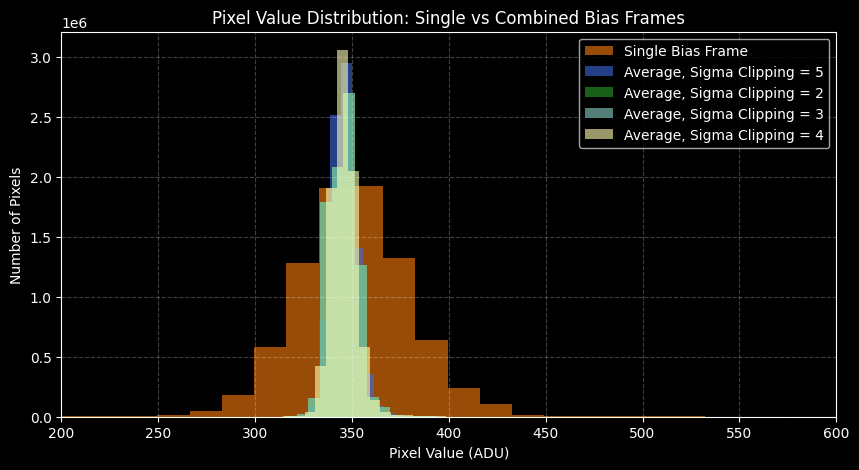

In [18]:
combined_bias_avg_sc2_hist = combined_bias_avg_sc2.data.flatten()
combined_bias_avg_sc3_hist = combined_bias_avg_sc2.data.flatten()
combined_bias_avg_sc4_hist = combined_bias_avg_sc4.data.flatten()

print(f'{"":<12}| {"Average, Sigma Clipping = 5":^30}| {"Average, Sigma Clipping = 2":^30}')
print('-' * 75)
print(f'{"Mean":<12}| {np.mean(combined_bias_avg.data):^30.2f}| {np.mean(combined_bias_avg_sc2.data):^30.2f}')
print(f'{"STD":<12}| {np.std(combined_bias_avg.data):^30.2f}| {np.std(combined_bias_avg_sc2.data):^30.2f}')
print(f'{"MAD STD":<12}| {mad_std(combined_bias_avg.data):^30.2f}| {mad_std(combined_bias_avg_sc2.data):^30.2f}')

print(f'{"":<12}| {"Average, Sigma Clipping = 5":^30}| {"Average, Sigma Clipping = 3":^30}')
print('-' * 75)
print(f'{"Mean":<12}| {np.mean(combined_bias_avg.data):^30.2f}| {np.mean(combined_bias_avg_sc3.data):^30.2f}')
print(f'{"STD":<12}| {np.std(combined_bias_avg.data):^30.2f}| {np.std(combined_bias_avg_sc3.data):^30.2f}')
print(f'{"MAD STD":<12}| {mad_std(combined_bias_avg.data):^30.2f}| {mad_std(combined_bias_avg_sc3.data):^30.2f}')

print(f'{"":<12}| {"Average, Sigma Clipping = 5":^30}| {"Average, Sigma Clipping = 4":^30}')
print('-' * 75)
print(f'{"Mean":<12}| {np.mean(combined_bias_avg.data):^30.2f}| {np.mean(combined_bias_avg_sc4.data):^30.2f}')
print(f'{"STD":<12}| {np.std(combined_bias_avg.data):^30.2f}| {np.std(combined_bias_avg_sc4.data):^30.2f}')
print(f'{"MAD STD":<12}| {mad_std(combined_bias_avg.data):^30.2f}| {mad_std(combined_bias_avg_sc4.data):^30.2f}')

plt.style.use("dark_background")
plt.figure(figsize=(10, 5))
plt.hist(bias_hist, bins=75, color='tab:orange', alpha=0.6, label='Single Bias Frame')
plt.hist(combined_bias_avg_hist, bins=75, color='royalblue', alpha=0.6, label='Average, Sigma Clipping = 5')
plt.hist(combined_bias_avg_sc2_hist, bins=75, color='tab:green', alpha=0.6, label='Average, Sigma Clipping = 2')
plt.hist(combined_bias_avg_sc3_hist, bins=75, alpha=0.6, label='Average, Sigma Clipping = 3')
plt.hist(combined_bias_avg_sc4_hist, bins=75, alpha=0.6, label='Average, Sigma Clipping = 4')
plt.title('Pixel Value Distribution: Single vs Combined Bias Frames')
plt.xlabel('Pixel Value (ADU)')
plt.ylabel('Number of Pixels')
plt.xlim(200, 600)
plt.grid(linestyle='dashed', alpha=0.25)
plt.legend()
plt.show()

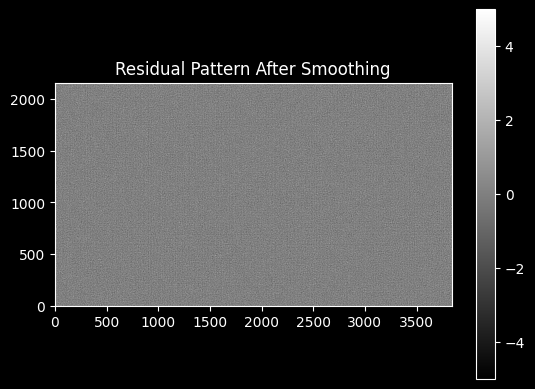

In [19]:
from scipy.ndimage import median_filter

residual = combined_bias_avg.data - median_filter(combined_bias_avg.data, size=25)

plt.imshow(residual, cmap='gray', origin='lower', vmin=-5, vmax=5)
plt.colorbar()
plt.title('Residual Pattern After Smoothing')
plt.show()

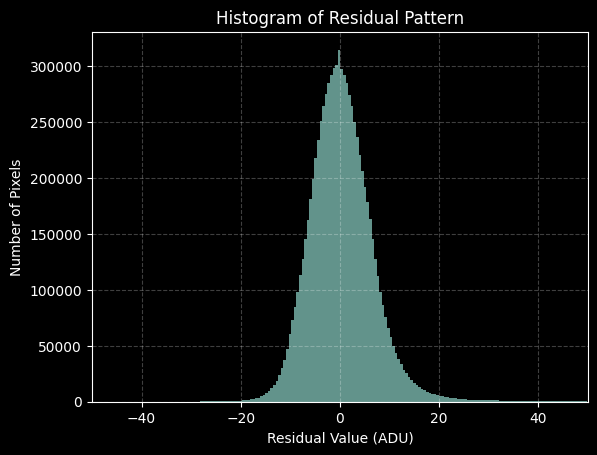

In [20]:
plt.hist(residual.flatten(), bins=800, alpha=0.7)
plt.title('Histogram of Residual Pattern')
plt.xlabel('Residual Value (ADU)')
plt.ylabel('Number of Pixels')
plt.grid(linestyle='dashed', alpha=0.25)
plt.xlim(-50,50)
plt.show()